In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Drag and drop kaggle.json at this point
!mv kaggle.json /root/.kaggle/

!kaggle datasets download -d balraj98/massachusetts-buildings-dataset

100% 1.49G/1.49G [00:48<00:00, 40.4MB/s]
100% 1.49G/1.49G [00:48<00:00, 32.9MB/s]


In [ ]:
!unzip -qq massachusetts-buildings-dataset.zip

In [ ]:
# Define the path of files to retrieve (only retrieve tiff files)

train_path = "/content/tiff/train"
train_labels_path = "/content/tiff/train_labels"

val_path = "/content/tiff/val"
val_labels_path = "/content/tiff/val_labels"

test_path = "/content/tiff/test"
test_labels_path = "/content/tiff/test_labels"

In the following cell, images were first sliced with (110, 1390) to get images of (1280, 1280) as 1280 was an integer multiple of 256 (Thus, all the image could be captured without a padding). Then, images of (256, 256) were acquired by a sliding window approach (as sliced data was shaped (1280, 1280), there were acquired 25 images of shape (256, 256))

Later, it was noticed that some images from the dataset had random crops. However, in this study, it was undesirable to have random crops in the input image itself. Therefore, parts of image that had pixels of pure white (rgb --> 255, 255, 255) in more than 25% were eliminated from the data.

An image with a big crop is shown below:

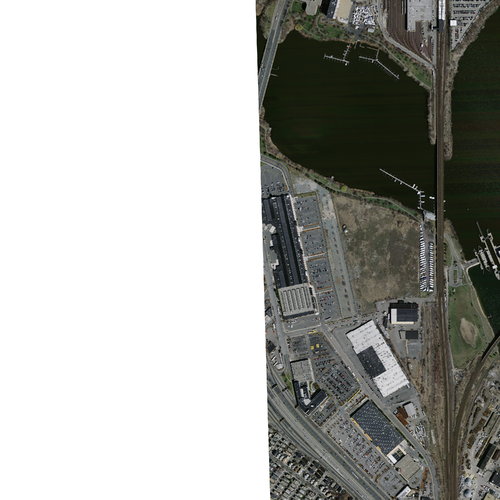

In [18]:
def get_images(path, labels_path, patch_size= 256, stride= 256):
  n = 1

  images = []
  masks = []
  white_ratios = []
  print(path, " Number of files: ", len(os.listdir(path)))
  for img_file in os.listdir(path):
    img = Image.open(path + "/"+img_file)
    mask = Image.open(labels_path + "/"+img_file[:-1]) # .tif instead of .tiff

    np_img = np.array(img)
    np_mask = np.array(mask)

    # crop to shape of (1280*1280) to be able to get 5 (256, 256) images
    np_img_resized = np_img[110:1390, 110:1390]
    np_mask_resized = np_mask[110:1390, 110:1390]

    height, width, _ = np_img_resized.shape

    for i in range(0, height, stride):
      for j in range(0, width, stride):
        img_ = np_img_resized[i:i+patch_size, j:j+patch_size]
        mask_ = np_mask_resized[i:i+patch_size, j:j+patch_size]

        # check percentage of white pixels
        number_of_white_pixels = np.sum(np.all(img_ == [255, 255, 255], axis=-1))
        number_of_pixels = img_.shape[0] * img_.shape[1]
        white_ratio = number_of_white_pixels/number_of_pixels
        white_ratios.append(white_ratio)

        if white_ratio > 0.25:
          print("skipping: ", img_file,  " White ratio: ", white_ratio, " position: ", i, j)
          n += 1
          continue
        images.append(np_img_resized[i:i+patch_size, j:j+patch_size])
        masks.append(np_mask_resized[i:i+patch_size, j:j+patch_size, 0])
  np_images = np.array(images)
  np_masks = np.array(masks)

  print("images shape: ",np_images.shape)
  print("masks shape: ", np_masks.shape)
  print(np.mean(white_ratios))
  print("there were ", n, "/", len(os.listdir(path)) * 25 ," patches skipped")
  return np_images, np_masks

In [19]:
train_images, train_mask = get_images(train_path, train_labels_path)
val_images, val_mask = get_images(val_path, val_labels_path)
test_images, test_mask = get_images(test_path, test_labels_path)

/content/tiff/train  Number of files:  137
skipping:  23279035_15.tiff  White ratio:  0.994232177734375  position:  0 768
skipping:  23279035_15.tiff  White ratio:  1.0  position:  0 1024
skipping:  23279035_15.tiff  White ratio:  0.9950103759765625  position:  256 768
skipping:  23279035_15.tiff  White ratio:  1.0  position:  256 1024
skipping:  23279035_15.tiff  White ratio:  0.9963531494140625  position:  512 768
skipping:  23279035_15.tiff  White ratio:  1.0  position:  512 1024
skipping:  23279035_15.tiff  White ratio:  0.996856689453125  position:  768 768
skipping:  23279035_15.tiff  White ratio:  1.0  position:  768 1024
skipping:  23279035_15.tiff  White ratio:  0.9945220947265625  position:  1024 768
skipping:  23279035_15.tiff  White ratio:  1.0  position:  1024 1024
skipping:  23129140_15.tiff  White ratio:  1.0  position:  0 0
skipping:  23129140_15.tiff  White ratio:  0.5476531982421875  position:  0 256
skipping:  23129140_15.tiff  White ratio:  0.9999847412109375  posit

In [23]:
print("images shape: ",train_images.shape, val_images.shape, test_images.shape)
print("masks shape:  ", train_mask.shape, val_mask.shape, test_mask.shape)

images shape:  (3106, 256, 256, 3) (100, 256, 256, 3) (250, 256, 256, 3)
masks shape:   (3106, 256, 256) (100, 256, 256) (250, 256, 256)


In [31]:
# plot images from train_images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
  x = random.choice(train_images)

  axes[i//5, i%5].imshow(x)
  axes[i//5, i%5].axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Below cell saves the computed images in the numpy array to a file.

In [32]:
import imageio

def save_images(images, masks, output_folder):
  # Directory to save TIFF images
  # output_folder = "train"

  # Create the output folder if it doesn't exist
  os.makedirs(output_folder, exist_ok=True)

  # Save each image as a TIFF file
  for i, image in enumerate(images):
    image_path = os.path.join(output_folder, f"image_{i+1}.tiff")
    imageio.imwrite(image_path, image)

  for i, mask in enumerate(masks):
      mask_path = os.path.join(output_folder, f"mask_{i+1}.tif")
      imageio.imwrite(mask_path, mask)

  print("TIFF images saved successfully.")

In [33]:
# save to seperate folders

save_images(train_images, train_mask, "train")
save_images(val_images, val_mask, "val")
save_images(test_images, test_mask, "test")

TIFF images saved successfully.
TIFF images saved successfully.
TIFF images saved successfully.


In [35]:
# zips the train val and test folders
!zip -r -q cropped_data.zip train val test

In [36]:
len(os.listdir("train")), len(os.listdir("val")), len(os.listdir("test"))

(6212, 200, 500)

In [37]:
# save to google drive
!cp cropped_data.zip /content/drive/MyDrive/buildingSegmentation/cropped_data_v4.zip